In [1]:
# Cell 1: Общее конфигурирование
from agentslab.utils.device import resolve_device
from agentslab.utils.seeding import set_global_seed
from pathlib import Path

device = resolve_device("cpu")
print('Device:', device)
 
seed = 42
set_global_seed(seed, deterministic=True)

ROOT = Path('..').resolve()
ALGO_NAME, ENV_NAME = "ppo", "pendulum"
ENV_ID = "InvertedDoublePendulum-v4"
# ENV_ID = "CartPole-v1"

Device: cpu


# Создание среды

In [2]:
from agentslab.envs.gym_factory import GymEnvConfig, make_gym_env
from torchrl.envs.utils import check_env_specs

env_cfg = GymEnvConfig(env_id=ENV_ID, render_mode=None, device=device, seed=seed)
env = make_gym_env(env_cfg)
check_env_specs(env)

# from agentslab.utils.specs import print_specs
# print_specs(env)

c:\Users\ordevoir\miniconda3\envs\marl\Lib\site-packages\torchrl\data\replay_buffers\samplers.py:36: UserWarning: Failed to import torchrl C++ binaries. Some modules (eg, prioritized replay buffers) may not work with your installation. This is likely due to a discrepancy between your package version and the PyTorch version. Make sure both are compatible. Usually, torchrl majors follow the pytorch majors within a few days around the release. For instance, TorchRL 0.5 requires PyTorch 2.4.0, and TorchRL 0.6 requires PyTorch 2.5.0.
  warnings.warn(EXTENSION_WARNING)


2025-08-22 15:02:39,676 [torchrl][INFO]    check_env_specs succeeded! [END]


# Создание актора и критика

In [3]:
from agentslab.modules.networks import MLPConfig, build_mlp
from agentslab.modules.policy import build_stochastic_actor
from torchrl.modules import ValueOperator

# Достаём размерности
obs_dim = env.observation_spec["observation"].shape[-1]
act_dim = env.action_spec.shape[-1]

mlp_cfg = MLPConfig(
        in_dim = obs_dim, 
        out_dim = 2*act_dim,
        hidden_sizes = (256, 256),
        activation = "tanh",
        layer_norm = False
)

actor_network = build_mlp(mlp_cfg)
actor = build_stochastic_actor(actor_network, env.action_spec)

mlp_cfg.out_dim = act_dim
critic_network = build_mlp(mlp_cfg)
critic = ValueOperator(module=critic_network, in_keys=["observation"])
critic

ValueOperator(
    module=Sequential(
      (0): Linear(in_features=11, out_features=256, bias=True)
      (1): Tanh()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): Tanh()
      (4): Linear(in_features=256, out_features=1, bias=True)
    ),
    device=cpu,
    in_keys=['observation'],
    out_keys=['state_value'])

# Collector

In [4]:
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage

frames_per_batch = 1000
# For a complete training, bring the number of frames up to 1M
total_frames = 10_000

collector = SyncDataCollector(
    create_env_fn=env,
    policy=actor,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

# Loss Function

In [5]:
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
import torch

gamma = 0.99
lmbda = 0.95

advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=critic, average_gae=True
)

clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
entropy_eps = 1e-4

loss_module = ClipPPOLoss(
    actor_network=actor,
    critic_network=critic,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coeff=entropy_eps,
    # these keys match by default but we set this for completeness
    critic_coeff=1.0,
    loss_critic_type="smooth_l1",
)

lr = 3e-4

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optim, 
    T_max=total_frames // frames_per_batch, 
    eta_min=0.0
)


# Logging

In [6]:
from __future__ import annotations
from pathlib import Path
from dataclasses import dataclass
from datetime import datetime
from typing import Dict, Iterable, Optional
import csv
import math
import torch
from torchrl.record.loggers import CSVLogger as TRL_CSVLogger, TensorboardLogger as TRL_TBLogger
from tqdm.auto import tqdm

# Исходные параметры пользователя
ROOT = Path('..').resolve()
ALGO_NAME, ENV_NAME = "ppo", "pendulum"


@dataclass
class RunPaths:
    run_dir: Path
    csv_dir: Path
    tb_dir: Path
    ckpt_dir: Path
    train_wide_csv: Path
    eval_wide_csv: Path

def make_run_dirs(algo: str, env: str, logs_root: Path = Path("./logs")) -> RunPaths:
    run_name = f"{algo}_{env}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    run_dir = logs_root / run_name
    csv_dir = run_dir / "csv"
    tb_dir = run_dir / "tb"
    ckpt_dir = run_dir / "checkpoints"
    # Папки логгеров TorchRL (создадутся сами), но базовые корни создадим сейчас
    for p in (run_dir, csv_dir, tb_dir, ckpt_dir):
        p.mkdir(parents=True, exist_ok=True)
    return RunPaths(
        run_dir=run_dir,
        csv_dir=csv_dir,
        tb_dir=tb_dir,
        ckpt_dir=ckpt_dir,
        train_wide_csv=csv_dir / "train_metrics.csv",
        eval_wide_csv=csv_dir / "eval_metrics.csv",
    )

class WideCSVWriter:
    """Простой 'wide' CSV: одна строка на шаг; детерминированный порядок колонок."""
    def __init__(self, filepath: Path, fieldnames: Iterable[str]):
        self.filepath = filepath
        self.fieldnames = list(fieldnames)  # фиксируем порядок
        new_file = not filepath.exists()
        self.fd = open(filepath, "a", newline="")
        self.writer = csv.DictWriter(self.fd, fieldnames=self.fieldnames)
        if new_file:
            self.writer.writeheader()
            self.fd.flush()

    def log_row(self, row: Dict):
        # Только известные поля, остальное игнорируем
        safe_row = {k: row.get(k, "") for k in self.fieldnames}
        self.writer.writerow(safe_row)
        self.fd.flush()

    def close(self):
        self.fd.close()

@dataclass
class Loggers:
    # TorchRL
    train_csv: TRL_CSVLogger
    eval_csv: TRL_CSVLogger
    train_tb: TRL_TBLogger
    eval_tb: TRL_TBLogger
    # Wide CSV
    train_wide: WideCSVWriter
    eval_wide: WideCSVWriter

def make_loggers(paths: RunPaths, hparams: Optional[Dict] = None) -> Loggers:
    # TorchRL CSV/TB: exp_name размежует train/eval, log_dir — корень вида .../csv и .../tb
    train_csv = TRL_CSVLogger(exp_name="train", log_dir=str(paths.csv_dir))
    eval_csv  = TRL_CSVLogger(exp_name="eval",  log_dir=str(paths.csv_dir))
    train_tb  = TRL_TBLogger(exp_name="train", log_dir=str(paths.tb_dir))
    eval_tb   = TRL_TBLogger(exp_name="eval",  log_dir=str(paths.tb_dir))

    if hparams:
        train_csv.log_hparams(hparams)
        train_tb.log_hparams(hparams)

    # 'Wide' CSV для удобного пост-анализа/графиков
    TRAIN_FIELDS = ["step", "frames", "reward_mean", "reward_std",
                    "episode_length_max", "loss_policy", "loss_value",
                    "loss_entropy", "loss_total", "lr", "grad_norm"]
    EVAL_FIELDS  = ["step", "frames", "return_mean", "return_std",
                    "episode_length_mean", "episode_length_max"]
    train_wide = WideCSVWriter(paths.train_wide_csv, TRAIN_FIELDS)
    eval_wide  = WideCSVWriter(paths.eval_wide_csv,  EVAL_FIELDS)

    return Loggers(train_csv, eval_csv, train_tb, eval_tb, train_wide, eval_wide)

# --- Универсальные функции логгирования ---------------------------------------

def log_metrics(
    mode: str,                   # "train" | "eval"
    metrics: Dict[str, float],   # только скаляры
    step: int,                   # глобальные кадры (frames)
    frames_added: int,
    logs: Loggers,
):
    """Логгирует в TorchRL CSV/TB и в 'wide' CSV."""
    assert mode in ("train", "eval")
    # 1) TorchRL TensorBoard: теги с префиксом
    tb = logs.train_tb if mode == "train" else logs.eval_tb
    for k, v in metrics.items():
        if isinstance(v, (float, int)) and (not (isinstance(v, float) and (math.isnan(v) or math.isinf(v)))):
            tb.log_scalar(f"{mode}/{k}", float(v), step=step)

    # 2) TorchRL CSV: по файлу на метрику (внутри .../csv/<mode>/scalars/<k>.csv)
    csvg = logs.train_csv if mode == "train" else logs.eval_csv
    for k, v in metrics.items():
        if isinstance(v, (float, int)) and (not (isinstance(v, float) and (math.isnan(v) or math.isinf(v)))):
            csvg.log_scalar(k, float(v), step=step)

    # 3) Wide CSV: один файл на режим
    row = {"step": step, "frames": frames_added, **metrics}
    wide = logs.train_wide if mode == "train" else logs.eval_wide
    wide.log_row(row)

# Progress Bar

In [7]:
def make_pbar(total_frames: int) -> tqdm:
    return tqdm(total=total_frames, dynamic_ncols=True, leave=True)

def update_pbar(pbar: tqdm, inc_frames: int, desc_parts: Dict[str, float]):
    # Аккуратное доприсвоение
    inc = min(int(inc_frames), pbar.total - pbar.n)
    if inc > 0:
        pbar.update(inc)
    # Короткое описание
    desc = ", ".join([f"{k}={v}" for k, v in desc_parts.items()])
    pbar.set_description(desc)

# Checkpointing

In [8]:
def save_checkpoint(
    paths: RunPaths,
    actor: torch.nn.Module,
    optim: torch.optim.Optimizer,
    scheduler,
    step: int,
    eval_metrics: Dict[str, float],
    is_best: bool = False,
):
    payload = {
        "step": step,
        "actor_state_dict": actor.state_dict(),
        "optimizer_state_dict": optim.state_dict(),
        "scheduler_state_dict": getattr(scheduler, "state_dict", lambda: {})(),
        "eval_metrics": eval_metrics,
    }
    ckpt_path = paths.ckpt_dir / f"step_{step:012d}.pt"
    torch.save(payload, ckpt_path)
    # Ссылка на последний и лучший
    latest = paths.ckpt_dir / "latest.pt"
    try:
        if latest.exists():
            latest.unlink()
        latest.symlink_to(ckpt_path.name)
    except Exception:
        torch.save(payload, latest)
    if is_best:
        torch.save(payload, paths.ckpt_dir / "best.pt")

# Training Loop

In [9]:
# Пример: total_frames, collector, advantage_module, replay_buffer, frames_per_batch,
# device, loss_module, optim, scheduler, env, actor — предполагаются определёнными выше.

from collections import defaultdict
from agentslab.runners.evals import eval_policy

# 0) Директории и логгеры
paths = make_run_dirs(ALGO_NAME, ENV_NAME)
hparams = {
    "algo": ALGO_NAME, "env": ENV_NAME,
    "total_frames": total_frames,
    "num_epochs": 10, "sub_batch_size": 64,
    "max_grad_norm": 1.0, "frames_per_batch": frames_per_batch,
}
logs = make_loggers(paths, hparams=hparams)

# 1) Основной цикл
global_frames = 0
best_eval_return = float("-inf")

pbar = make_pbar(total_frames)

max_grad_norm = 1.0
num_epochs = 10
sub_batch_size = 64

for i, tensordict_data in enumerate(collector):
    # ====== Шаг обучения ======
    # Пересчёт advantages один раз на 'view' данных
    for _ in range(num_epochs):
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())

        # усредняем лоссы по внутренним апдейтам
        acc = defaultdict(float)
        gn_acc = 0.0
        gn_count = 0

        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_total = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            loss_total.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

            # аккумулируем
            acc["loss_policy"]  += loss_vals["loss_objective"].item()
            acc["loss_value"]   += loss_vals["loss_critic"].item()
            acc["loss_entropy"] += loss_vals["loss_entropy"].item()
            acc["loss_total"]   += loss_total.item()
            gn_acc += float(grad_norm)
            gn_count += 1

    scheduler.step()

    # ====== Метрики train ======
    rew = tensordict_data.get(("next", "reward"))
    step_count = tensordict_data.get(("step_count"))
    reward_mean = float(rew.mean().item())
    reward_std  = float(rew.std(unbiased=False).item())
    episode_length_max = int(step_count.max().item())
    lr = float(optim.param_groups[0]["lr"])

    # средние по апдейтам
    if gn_count > 0:
        train_metrics = {
            "reward_mean": reward_mean,
            "reward_std": reward_std,
            "episode_length_max": episode_length_max,
            "loss_policy":  acc["loss_policy"]  / gn_count,
            "loss_value":   acc["loss_value"]   / gn_count,
            "loss_entropy": acc["loss_entropy"] / gn_count,
            "loss_total":   acc["loss_total"]   / gn_count,
            "lr": lr,
            "grad_norm": gn_acc / gn_count,
        }
    else:
        train_metrics = {
            "reward_mean": reward_mean,
            "reward_std": reward_std,
            "episode_length_max": episode_length_max,
            "lr": lr,
        }

    # корректное число фреймов в пачке
    batch_frames = int(rew.numel())
    global_frames += batch_frames

    # Логгируем train
    log_metrics("train", train_metrics, step=global_frames, frames_added=batch_frames, logs=logs)

    # ====== Eval + чекпоинт каждые 5 партий ======
    if (i + 1) % 5 == 0:
        eval_results = eval_policy(env, actor, episodes=5, progress=False)
        # ожидаемые ключи — подстрахуемся на варианты
        eval_metrics = {
            "return_mean": float(eval_results.get("return_mean", eval_results.get("avg_return", 0.0))),
            "return_std":  float(eval_results.get("return_std",  0.0)),
            "episode_length_mean": float(eval_results.get("episode_length_mean", eval_results.get("avg_episode_length", 0.0))),
            "episode_length_max":  float(eval_results.get("max_episode_lengh", eval_results.get("max_episode_length", 0.0))),
        }

        # лог
        log_metrics("eval", eval_metrics, step=global_frames, frames_added=batch_frames, logs=logs)
        pbar.write(f"eval: avg reward = {eval_metrics['return_mean']:.3f}, max episode length = {eval_metrics['episode_length_max']}")

        # чекпоинт
        is_best = eval_metrics["return_mean"] > best_eval_return
        if is_best:
            best_eval_return = eval_metrics["return_mean"]
        save_checkpoint(paths, actor, optim, scheduler, step=global_frames, eval_metrics=eval_metrics, is_best=is_best)

    # ====== прогресс-бар ======
    update_pbar(
        pbar,
        inc_frames=batch_frames,
        desc_parts={
            "avg_reward": f"{train_metrics['reward_mean']:.4f}",
            "max_len": episode_length_max,
            "lr": f"{lr:.4f}",
        },
    )

pbar.close()

# После окончания можно (не обязательно) закрыть файлы wide CSV вручную:
logs.train_wide.close()
logs.eval_wide.close()

print(f"Run dir: {paths.run_dir}")
print(f"Train CSV (wide): {paths.train_wide_csv}")
print(f"Eval  CSV (wide): {paths.eval_wide_csv}")
print(f"TensorBoard: {paths.tb_dir}  ->  `tensorboard --logdir {paths.tb_dir}`")

  0%|          | 0/10000 [00:00<?, ?it/s]

eval: avg reward = 154.026, max episode length = 21.0
eval: avg reward = 142.631, max episode length = 16.0
Run dir: logs\ppo_pendulum_20250822_150240
Train CSV (wide): logs\ppo_pendulum_20250822_150240\csv\train_metrics.csv
Eval  CSV (wide): logs\ppo_pendulum_20250822_150240\csv\eval_metrics.csv
TensorBoard: logs\ppo_pendulum_20250822_150240\tb  ->  `tensorboard --logdir logs\ppo_pendulum_20250822_150240\tb`


# Graphs

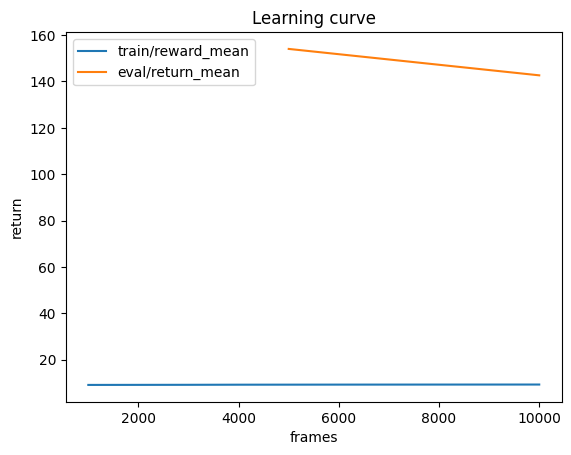

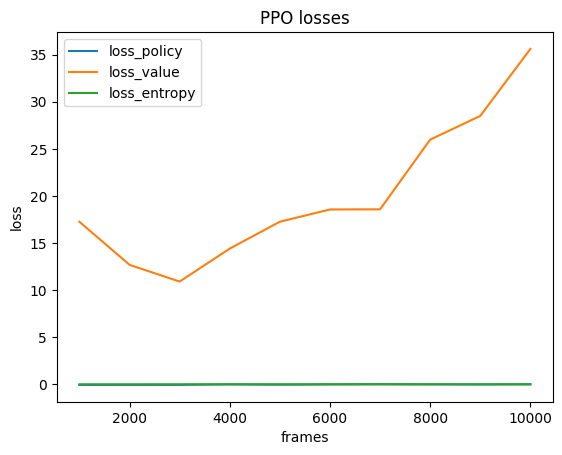

In [10]:
# Пример: быстрые графики из wide CSV
import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.read_csv(paths.train_wide_csv)
eval_df  = pd.read_csv(paths.eval_wide_csv)

plt.figure()
plt.plot(train_df["step"], train_df["reward_mean"], label="train/reward_mean")
plt.plot(eval_df["step"],  eval_df["return_mean"],  label="eval/return_mean")
plt.xlabel("frames"); plt.ylabel("return"); plt.legend(); plt.title("Learning curve")

plt.figure()
plt.plot(train_df["step"], train_df["loss_policy"], label="loss_policy")
plt.plot(train_df["step"], train_df["loss_value"],  label="loss_value")
plt.plot(train_df["step"], train_df["loss_entropy"], label="loss_entropy")
plt.xlabel("frames"); plt.ylabel("loss"); plt.legend(); plt.title("PPO losses")
plt.show()


# Evaluating

In [11]:
from agentslab.runners.evals import eval_policy

eval_policy(env, actor, episodes=50)

eval:   0%|          | 0/50 [00:00<?, ?it/s]

{'return_mean': 179.49685134887696,
 'return_sum': 8974.842567443848,
 'max_episode_lengh': 33,
 'num_episodes': 50}